In [1]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

print('Done importing')

Done importing


In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER) yuxinhuang
Enter password: (+ENTER) ········


In [2]:
ac.whoAmI()

'yuxinhuang'

In [5]:
print(qc.schema('des_dr1'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
       tile_info   Survey tile information table
  x_gaia_dr2_2p5   Gaia DR1 2.5 arcsec xmatch v. DES



In [8]:
print(qc.schema('des_dr1.main'))


Schema: des_dr1
 Table: main

     Column Name   Description
     -----------   -----------
 coadd_object_id   Unique identifier for the coadded objects
         hpix_32   Healpix ID for nside=32, nested schema
         hpix_64   Healpix ID for nside=64, nested schema
       hpix_1024   Healpix ID for nside=1024, nested schema
       hpix_4096   Healpix ID for nside=4096, nested schema
      hpix_16384   Healpix ID for nside=16384, nested schema
              ra   Right ascension, with quantized precision for indexing (AL
                   PHAWIN_J2000 has full precision but not indexed)
             dec   Declination, with quantized precision for indexing (DELTAW
                   IN_J2000 has full precision but not indexed)
  alphawin_j2000   Right ascension for the object, J2000 in ICRS system (full
                   precision but not indexed)
  deltawin_j2000   Declination for the object, J2000 in ICRS (full precision 
                   but not indexed)
      galactic_l   Gala

In [42]:
RA180924 = 21 + 44/60 + 25/3600
RA191001 = 21 + 33/60 + 24/3600
RA181112 = 21 + 49/60 + 23/3600

DEC180924 = - (40 + 54/60)
DEC191001 = - (54 + 44/60 + 54/3600)
DEC181112 = - (52 + 58/60 + 15/3600)

In [43]:
print(RA180924, DEC180924)

21.740277777777777 -40.9


In [3]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-21.74<1 and ra-21.74>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5)
        LIMIT 100"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-21.74<1 and ra-21.74>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5)
        LIMIT 100


In [4]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df = convert(res,'pandas')

CPU times: user 87 ms, sys: 3 ms, total: 90 ms
Wall time: 2.42 s


In [5]:
print(df[:5])
len(df)

        gmag       rmag       zmag       imag       ymag  class_star_g  \
0  24.800497  24.101427  24.357584  24.194246  24.265047      0.405264   
1  23.103910  22.867956  22.280659  22.733511  21.900438      0.070160   
2  23.864510  23.489162  23.194036  23.282154  22.548466      0.763179   
3  16.113823  15.808522  15.740534  16.034166  15.764551      0.999020   
4  25.277386  24.393557  24.483091  24.153708  99.000000      0.385805   

   class_star_r  class_star_z       snr_g       snr_r       snr_z         ra  \
0      0.456862      0.400519     4.61409     6.27440     1.32450  22.164050   
1      0.007835      0.028755    13.87390    11.29350     5.24280  22.166567   
2      0.082571      0.642360     7.26122     8.32785     2.77104  22.181421   
3      0.999796      0.993259  2329.04000  2899.22000  1580.62000  22.171716   
4      0.443613      0.409181     3.34696     5.35421     1.32741  22.175945   

         dec  
0 -41.898824  
1 -41.897179  
2 -41.898548  
3 -41.898889  

100000

In [13]:
ra = df['ra'][:]
dec = df['dec'][:]
rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]

Text(0, 0.5, 'dec')

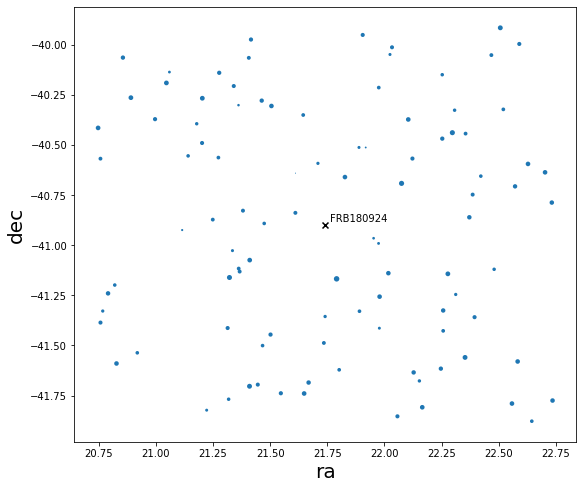

In [60]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
ax1.scatter(col0, col1, marker='o', s = -29/(max(rmag)-min(rmag)) * rmag + (29/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
